In [104]:
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install scikit-learn

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, RNN

In [352]:
def create_dataset(signal, window_size=20):
    X, y = [], []
    for i in range(len(signal) - window_size):
        X.append(signal[i:i+window_size])
        y.append(signal[i+window_size])
    return np.array(X), np.array(y)

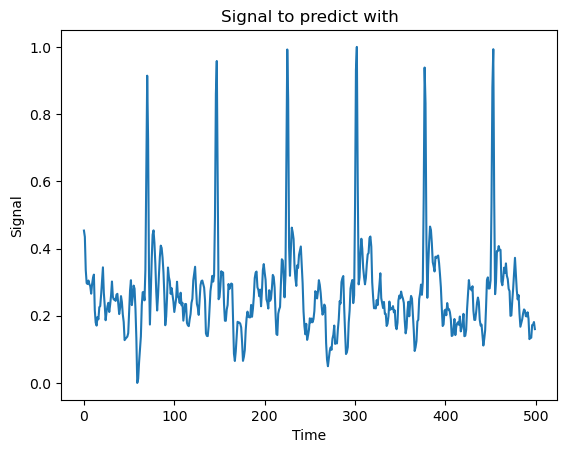

In [430]:
data = pd.read_csv('data/sparc_data_augmented.csv')
extracted_data = data.iloc[:, 1::].to_numpy()

clean_data = pd.read_csv('data/sparc_data.csv')
original_signal = clean_data.iloc[:, 1::].to_numpy()

scaler = MinMaxScaler(feature_range=(0,1))
og_scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(extracted_data)
scaled_original_signal = og_scaler.fit_transform(original_signal)

plt.plot(scaled_original_signal)
plt.title('Signal to predict with')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

In [431]:
X_train_all, y_train_all = [], []
window_size = 20

for i in range(scaled_data.shape[1]):  # a list of 10 signals
    X_aug, y_aug = create_dataset(scaled_data[:, i], window_size)
    X_train_all.append(X_aug)
    y_train_all.append(y_aug)

# Combine all augmented data into single arrays
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Reshape if univariate (LSTM expects shape (samples, timesteps, features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [432]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='relu', input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [436]:
model.fit(X_train, y_train, epochs=35, batch_size=32, validation_split=0.2)

Epoch 1/50
600/600 [==============================] - 23s 39ms/step - loss: 0.0067 - val_loss: 0.0060
Epoch 2/50
600/600 [==============================] - 24s 40ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 3/50
600/600 [==============================] - 24s 40ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 4/50
600/600 [==============================] - 28s 46ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 5/50
600/600 [==============================] - 43s 72ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 6/50
600/600 [==============================] - 52s 87ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 7/50
600/600 [==============================] - 48s 80ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 8/50
600/600 [==============================] - 53s 88ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 9/50
600/600 [==============================] - 50s 83ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 10/50
600/600 [==============================] - 28s 47ms/step - loss: 0.005

In [437]:
seed_sequence = np.copy(scaled_original_signal[-window_size:]) 

# List to store predictions
predictions = []
nb_predictions = 100

# Make n predictions
for i in range(nb_predictions):
    # Reshape to model input shape: (1, window_size, 1)
    input_seq = np.reshape(seed_sequence[i:window_size+i], (1, window_size, 1))
    
    # Predict next value (shape will be (1, 1))
    next_val = model.predict(input_seq, verbose=0)[0, 0]
    
    # Append prediction to results
    predictions.append(next_val)
    seed_sequence = np.append(seed_sequence, next_val)
    
predictions = og_scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

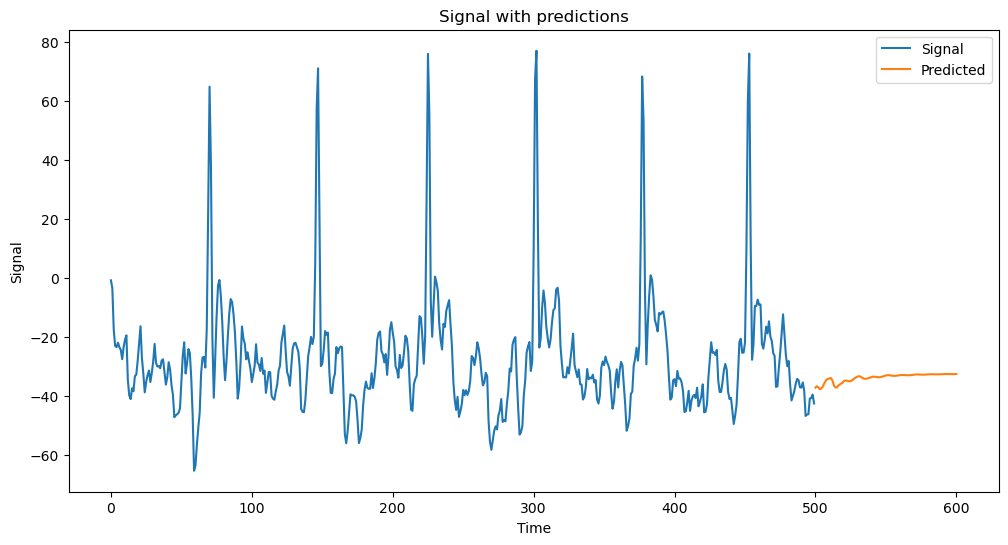

In [438]:
plt.figure(figsize=(12, 6))
plt.plot(original_signal, label='Signal')
plt.plot(np.linspace(len(original_signal), len(original_signal) + nb_predictions, nb_predictions),predictions, label='Predicted')
plt.title('Signal with predictions')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.show()